In [ ]:
def unzip_data(url, fname=None, dest=None, force_download=False):
    from urllib.request import urlopen
    from zipfile import ZipFile
    import os
    import shutil
    from pathlib import Path
    filename = url.rpartition('/')[2]
    foldername = filename.split('.')[0]
    if os.path.exists(f'{dest}/{foldername}'):
        print('Already Downloaded')
        if force_download:
            print('Removing Old Downloaded')
            shutil.rmtree(f'{dest}/{foldername}')
        else:
            return Path(f'{dest}/{foldername}')
    print('Downloading from remote server')
    response = urlopen(url)
    if dest is None: dest = '.'
    tmpzip = open(f'{dest}/{filename}', 'wb')
    tmpzip.write(response.read())
    tmpzip.close()
    zf = ZipFile(f'{dest}/{filename}')
    zf.extractall(path = dest)
    os.remove(f'{dest}/{filename}')
    return Path(f'{dest}/{foldername}')
    

In [ ]:
from fastai.vision import *

In [4]:
path = unzip_data('http://files.fast.ai/data/dogscats.zip', dest='sample_data')

In [39]:
list(iter(path.iterdir()))

[PosixPath('sample_data/dogscats/models'),
 PosixPath('sample_data/dogscats/valid'),
 PosixPath('sample_data/dogscats/train'),
 PosixPath('sample_data/dogscats/sample'),
 PosixPath('sample_data/dogscats/test1')]

In [ ]:
path_val = path/'valid'
path_train = path/'train'

In [43]:
files = get_image_files(path_val/'cats'); files[:5]

[PosixPath('sample_data/dogscats/valid/cats/cat.8445.jpg'),
 PosixPath('sample_data/dogscats/valid/cats/cat.10356.jpg'),
 PosixPath('sample_data/dogscats/valid/cats/cat.6523.jpg'),
 PosixPath('sample_data/dogscats/valid/cats/cat.9358.jpg'),
 PosixPath('sample_data/dogscats/valid/cats/cat.10919.jpg')]

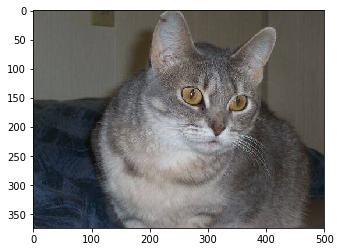

In [48]:
img = plt.imread(files[0])
plt.imshow(img);

In [49]:
img.shape

(374, 500, 3)

In [51]:
img[:4, :4]

array([[[100,  99,  95],
        [100,  99,  95],
        [101, 100,  96],
        [101, 100,  96]],

       [[100,  99,  95],
        [100,  99,  95],
        [101, 100,  96],
        [101, 100,  96]],

       [[100,  99,  95],
        [100,  99,  95],
        [101, 100,  96],
        [101, 100,  96]],

       [[100,  99,  95],
        [100,  99,  95],
        [101, 100,  96],
        [101, 100,  96]]], dtype=uint8)

In [ ]:
size = 224
bs = 64

In [ ]:
tfms = get_transforms()
data = (ImageDataBunch.from_folder(path, train='train', valid='valid', test='test',
                                  size=size, bs=bs)
        .normalize(imagenet_stats))

In [55]:
data.classes

['cats', 'dogs']

In [56]:
data.c

2

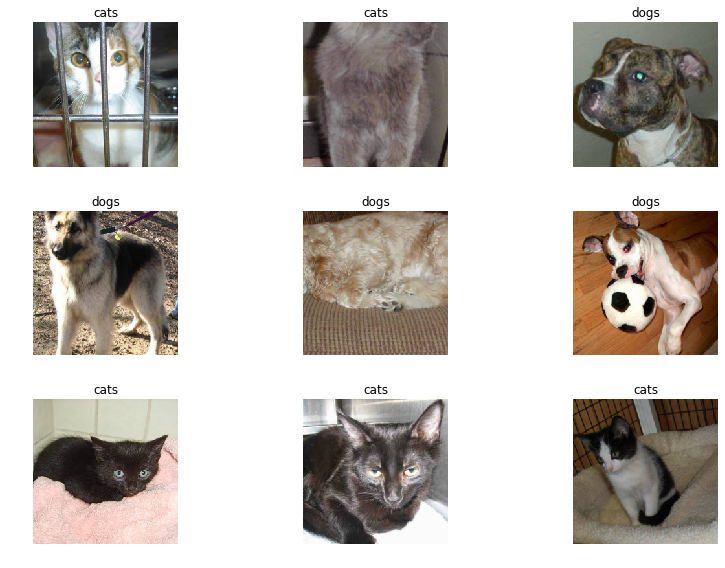

In [57]:
data.show_batch(rows=3, figsize=(12, 8))

In [ ]:
learner = cnn_learner(data, models.resnet34, metrics=accuracy)

In [59]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


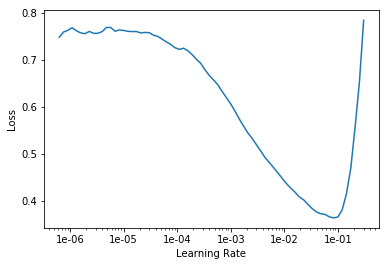

In [60]:
learner.recorder.plot()

In [61]:
learner.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.092615,0.070579,0.975500,03:15
1,0.050273,0.031727,0.989000,03:15


In [ ]:
learner.save('stage-1')

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

In [71]:
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

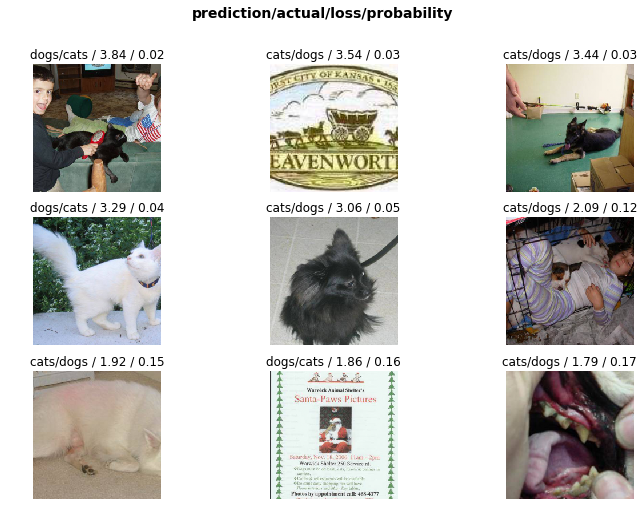

In [72]:
interp.plot_top_losses(9, figsize=(12, 8), heatmap=False)

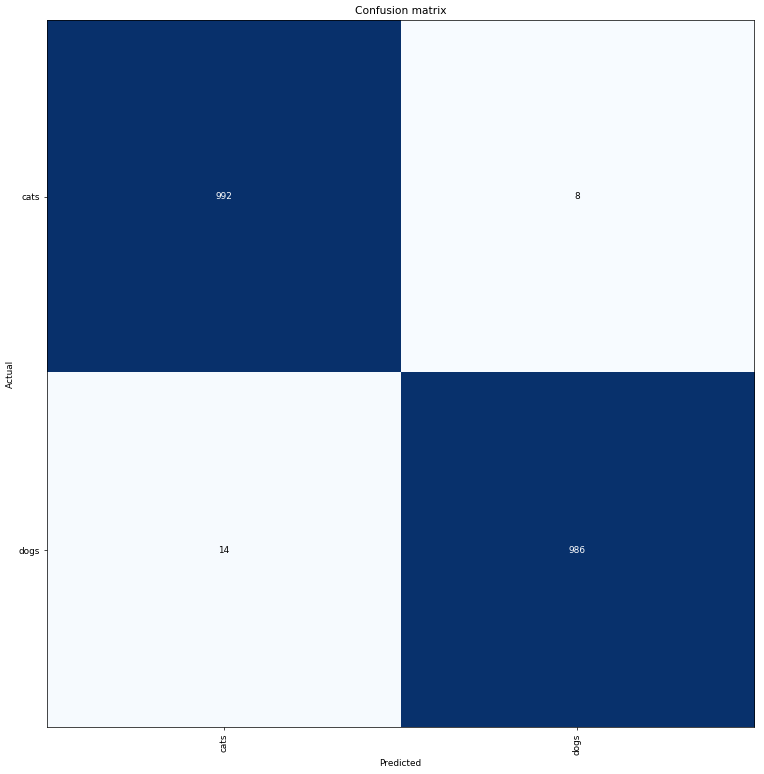

In [73]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=64)

In [74]:
interp.most_confused(min_val=2)

[('dogs', 'cats', 14), ('cats', 'dogs', 8)]

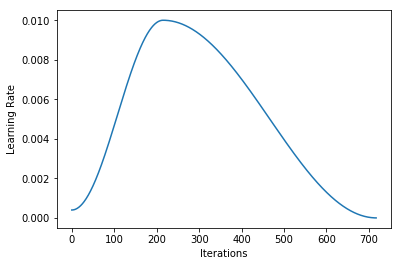

In [76]:
learner.recorder.plot_lr()

In [ ]:
learner.unfreeze()

In [ ]:
lr = slice(1e-4, 1e-2)

In [82]:
learner.fit_one_cycle(3, lr,  tot_epochs=2)

epoch,train_loss,valid_loss,accuracy,time
0,0.122347,0.107864,0.957500,03:27
1,0.047918,0.045815,0.982000,03:24


In [ ]:
learner = cnn_learner(data, models.resnet34, metrics=accuracy, 
                      callback_fns=partial(GradientClipping, clip=0.1))

In [85]:
learner.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.054462,0.039344,0.987500,03:16


In [ ]:
tfms = get_transforms()
data = (ImageDataBunch.from_folder(path, train='train', valid='valid', test='test',
                                  size=size, bs=bs, ds_tfms=tfms)
        .normalize(imagenet_stats))

In [ ]:
learner = cnn_learner(data, models.resnet34, metrics=accuracy, 
                      callback_fns=[partial(GradientClipping, clip=0.1), BnFreeze])

In [104]:
learner.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.092524,0.031225,0.991000,04:42
1,0.050888,0.027930,0.992500,04:47


In [ ]:
# # all layers now trainable
# learn.unfreeze()
# # optionally, separate LR and WD for each group
# learn.fit_one_cycle(1, max_lr=(1e-4, 1e-3, 1e-2), wd=(1e-4,1e-4,1e-1))


In [105]:
interp = ClassificationInterpretation.from_learner(learner, tta=True)

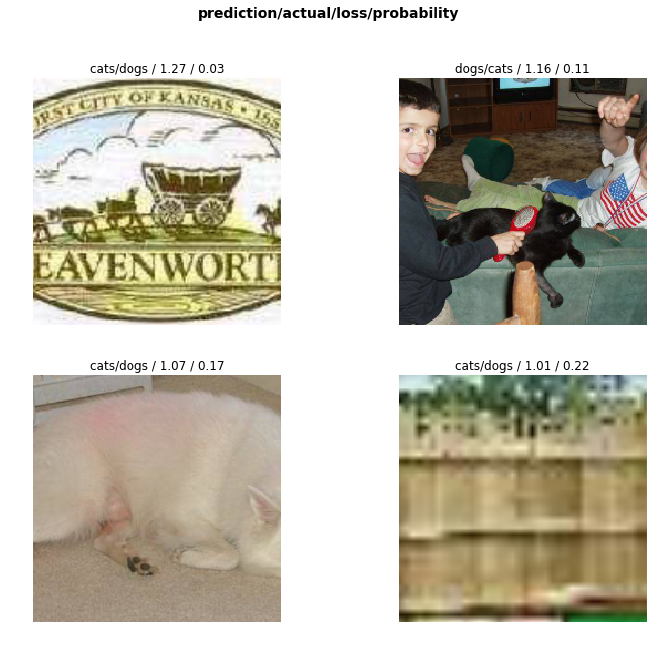

In [109]:
interp.plot_top_losses(4, figsize=(12,10), heatmap=False)

In [ ]:
probs = interp.probs

In [ ]:
y = interp.y_true

In [113]:
accuracy(probs, y)

tensor(0.9935)

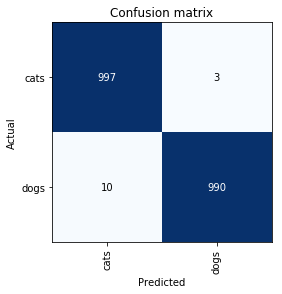

In [114]:
interp.plot_confusion_matrix()

In [115]:
interp.most_confused()

[('dogs', 'cats', 10), ('cats', 'dogs', 3)]

In [ ]:
def plot_most_confused(y_hat, y):
    preds = np.argmax(y_hat, axis=1)
    errors = np.where(preds!=y)[0]
    n = errors.shape[0]
    rows = 3
    cols = n // rows
#     fig = plt.figure(figsize=(8, 6))
    for _, idx in enumerate(errors):
        show_image((interp.data.valid_ds[idx])[0])
    

In [1]:
plot_most_confused(probs, y)

NameError: ignored

In [117]:
preds = np.argmax(probs, axis=1); preds

tensor([0, 0, 0,  ..., 1, 1, 1])

In [135]:
y[preds!=y]

tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

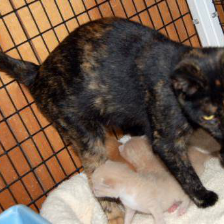

In [177]:
(interp.data.valid_ds[405])[0]

In [172]:
np.where(preds!=y)[0].shape[0]

13

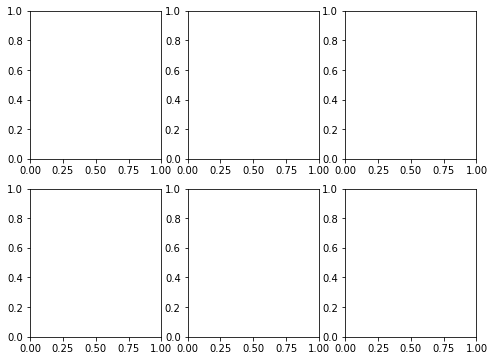

In [173]:
fig, axes = subplots(2, 3, figsize=(8, 6))

In [174]:
axes.flatten()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa060184390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fa04cfdae80>], dtype=object)